<a href="https://colab.research.google.com/github/joapen/ML-Learning-bucket/blob/main/LSTM_on_1_Stock_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose of Code = We normalize the data and apply LSTM (Long-Short Term Memory neural network)


1.- Load libraries common data and functions
2.- Preparing the data for LSTM
3.- Split Train/Test dataset & dimension the data vectors
4.- Creating the LSTM model
5.- Build prediction on test dataset
6.- Predict the stock price for tomorrow
10.- Analysis: Generate and save data to analyze results
20.- Generate Next day result

One property used: close price.

Source = https://thinkingneuron.com/predicting-stock-prices-using-deep-learning-lstm-model-in-python/

### 1.- Load Libraries

In [5]:
#### libraries ###
## -> Always

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle # to save in disk the model and recuperate it

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

print("Setup Complete")

Setup Complete


## 1.- Load common data and functions

In [6]:
## -> Functions (Always)

def buildLastDaysArray(input_array, data_scaler, nSamples,timeSteps, nFeatures):
  # Last X days prices where X = time_step
  LastXDays=np.array(input_array)

  # Normalizing the data just like we did for training the model
  LastXDays=data_scaler.transform(LastXDays.reshape(-1,1))

  # Changing the shape of the data to 3D
  LastXDays=LastXDays.reshape(nSamples,timeSteps,nFeatures)
  return LastXDays

def initiateDataLoad(sTicker):
  query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{sTicker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
  StockData = pd.read_csv(query_string)
  StockData.Date = pd.to_datetime(StockData['Date'],format='%Y/%m/%d')
  StockData.set_index('Date')

  ## Prepare data
  # Extracting the closing prices of each day
  FullData=StockData[['Close']].values

  DataScaler = initiateDataScaler(FullData)
  X=DataScaler.transform(FullData)
  #X=FullData
  
  # Creating a column as date
  StockData['TradeDate']=StockData.Date

  return FullData, StockData, DataScaler, X

def initiateDataScaler(inputData):
  # Feature Scaling for fast training of neural networks
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
  # Choosing between Standardization or normalization
  #sc = StandardScaler()
  sc = MinMaxScaler()
  
  DataScaler = sc.fit(inputData)
  return DataScaler
 

In [7]:
###   Load market data from yahoo    ###
## -> Always
## -> change =  date and ticker
import time
import datetime
import pandas as pd
###  Project Definition  ###
PROJECT_ID = 'Predicting stock prices of an individual Stock using Long-Short Term Model (LSTM)'
#####################################
### Parameters to be changed here ###
interval = '1d'
period1 = int(time.mktime(datetime.datetime(1986, 3, 12, 23, 59).timetuple()))    # start date for the stock
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))   # last day of the stock
tickers = ['MSFT', 'GOOG', 'AAPL', 'FB'] # list of tickers to be considered
ticker = "MSFT" # the stock used for modelling

sURL = "/content/drive/MyDrive/public/DREAM/"  # Route for saved model
filename = 'LSTM-on-'+ticker+'-v1-model.sav'   # Filename for saved the model
saveModelLocation = sURL+filename              # file location for saved model

NumSamples=1      # number of samples, initially 1
TimeSteps=10      # initially 10 days
NumFeatures=1     # nFeatures used in the X array
#####################################

FullData, StockData, DataScaler, X = initiateDataLoad(ticker)

print("Setup Complete")

Setup Complete


In [ ]:
## Optional, Plotting the stock prices
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

## 2.- Preparing the data for LSTM

In [10]:
## -> To model

### 2.1 split into samples ###

X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# 2.2 Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('Input Data shape = ' + str(X_data.shape))
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('Output Data shape = ' + str(y_data.shape))

Input Data shape = (9037, 10, 1)
Output Data shape = (9037, 1)


## 3.- Split Train/Test dataset & dimension the data vectors

In [11]:
## -> To model

# Choosing the number of testing data records

TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(9032, 10, 1)
(9032, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [ ]:
## Optional = Visualizing the input and output data for LSTM

# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[2.02437349e-05]
 [3.03656023e-05]
 [3.54294513e-05]
 [2.78351354e-05]
 [2.27742017e-05]
 [1.51828011e-05]
 [7.59140057e-06]
 [0.00000000e+00]
 [5.06093371e-06]
 [1.26523343e-05]] -- [1.7713268e-05]
[[3.03656023e-05]
 [3.54294513e-05]
 [2.78351354e-05]
 [2.27742017e-05]
 [1.51828011e-05]
 [7.59140057e-06]
 [0.00000000e+00]
 [5.06093371e-06]
 [1.26523343e-05]
 [1.77132680e-05]] -- [1.51828011e-05]


## 4.- Creating the LSTM model


This time I'm going to use LSTM neural network.
* https://en.wikipedia.org/wiki/Long_short-term_memory
* https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

Notes:
* Pytorch’s LSTM expects all of its inputs to be 3D tensors.
* The semantics of the axes of these tensors is important.
* The first axis is the sequence itself,
* The second indexes instances in the mini-batch,
* The third indexes elements of the input.
* Let's ignore 2º axis (mini-batching), we will always have just 1D.

In [12]:
## -> To model

###################################
###   1 hour step!!!!!!!! when epochs = 100
###################################

# 4.1 Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)
# 4.2 Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'tanh', return_sequences=False ))

# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

##################################################
import time
# Measuring the time taken by the model to train
StartTime=time.time()
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Number of TimeSteps: 10
Number of Features: 1
Epoch 1/100
1807/1807 [==============================] - 35s 16ms/step - loss: 0.0013
Epoch 2/100
1807/1807 [==============================] - 25s 14ms/step - loss: 1.2373e-04
Epoch 3/100
1807/1807 [==============================] - 26s 14ms/step - loss: 1.0116e-04
Epoch 4/100
1807/1807 [==============================] - 25s 14ms/step - loss: 1.0831e-04
Epoch 5/100
1807/1807 [==============================] - 26s 14ms/step - loss: 9.3306e-05
Epoch 6/100
1807/1807 [==============================] - 25s 14ms/step - loss: 1.0365e-04
Epoch 7/100
1807/1807 [==============================] - 25s 14ms/step - loss: 8.8947e-05
Epoch 8/100
1807/1807 [==============================] - 25s 14ms/step - loss: 9.0281e-05
Epoch 9/100
1807/1807 [==============================] - 25s 14ms/step - loss: 8.3123e-05
Epoch 10/100
1807/1807 [==============================] - 25s 14ms/step - loss: 9.2724e-05
Epoch 11/100
1807/1807 [==============================] -

## 5.- Build prediction on test dataset

In [13]:
## -> To model

# 5.1 Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

Accuracy: 98.88557812895812


In [14]:
## -> To model

###  5.3 Generating predictions on full data

TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

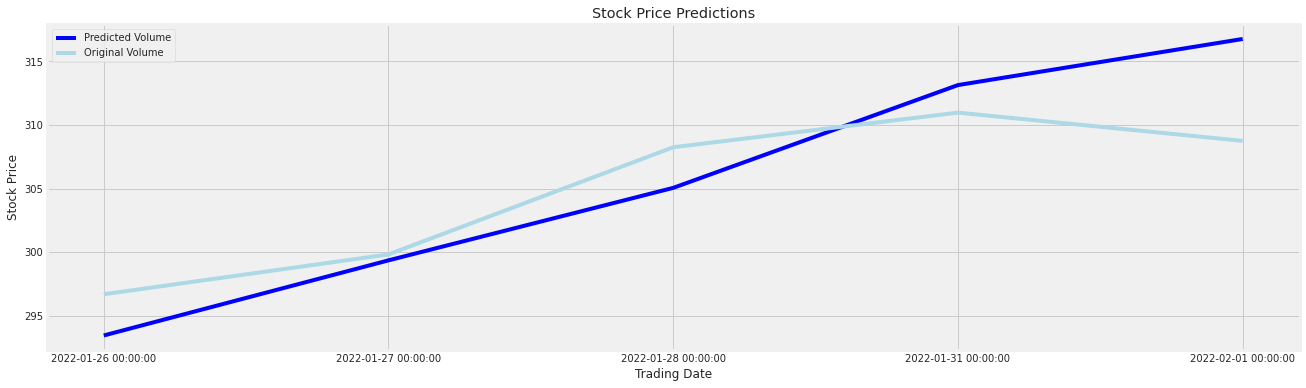

In [15]:
# 5.2 Optional: Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

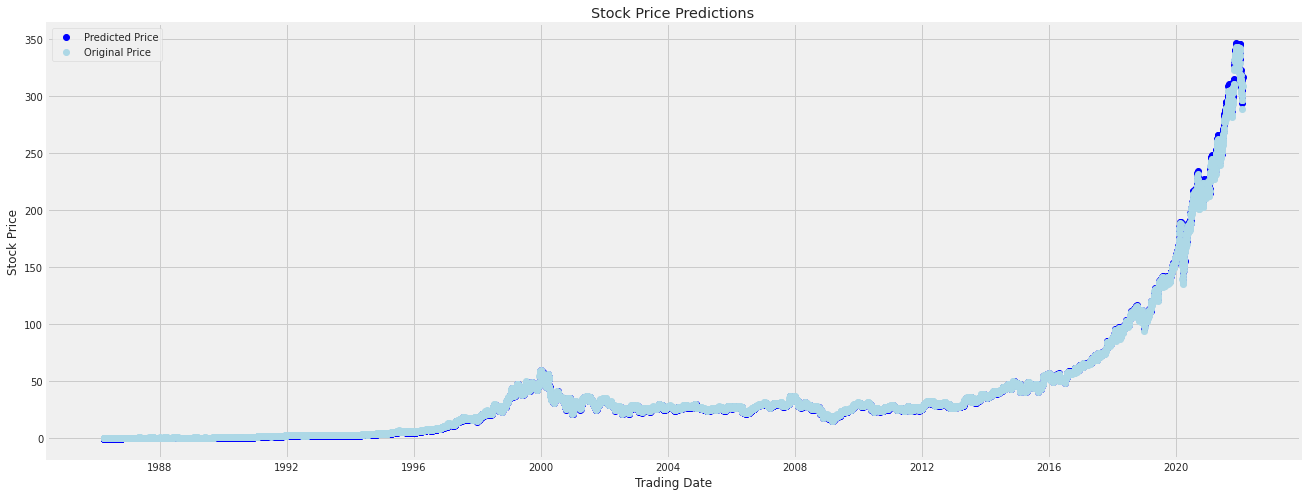

In [16]:
# 5.4 plotting the full data
plt.plot_date(StockData.Date[TimeSteps:], FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot_date(StockData.Date[TimeSteps:], FullDataOrig , color = 'lightblue', label = 'Original Price')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## 6.- Predict the stock price for tomorrow

In [17]:
## Model
## When = predict next day based on live model (not saved model)
Last10Days = buildLastDaysArray(FullData[-1*TimeSteps:], DataScaler, NumSamples,TimeSteps, NumFeatures)
# 6.1 Building predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('Last day      =' + str(FullData[-1:]))
print('Prediction    =' + str(predicted_Price))
difference = (predicted_Price - FullData[-1:]) / FullData[-1:] *100
print('Difference (%)=' + str(difference))

Last day      =[[308.76001]]
Prediction    =[[313.97186]]
Difference (%)=[[1.68799476]]


In [18]:
## -> To model
# 6.2 Save the generated model to disk
pickle.dump(regressor, open(saveModelLocation, 'wb'))
print('model saved on ' + saveModelLocation)

INFO:tensorflow:Assets written to: ram://61d62865-bf79-4d94-81d1-d4574a8b75fc/assets


INFO:tensorflow:Assets written to: ram://61d62865-bf79-4d94-81d1-d4574a8b75fc/assets


model saved on /content/drive/MyDrive/public/DREAM/LSTM-on-MSFT-v1-model.sav


## 10.- Analysis: Generate and save data to analyze results

In [19]:
### When = Only analysis, after modelling
# 6.1 build difference dataframe
resultsChange = FullDataOrig.reshape(-1) - FullDataPredictions
resultsDF = pd.DataFrame({'Orig' : FullDataOrig.reshape(-1),
                          'Pred' : FullDataPredictions.tolist(),
                          'Date' : StockData.Date[TimeSteps:],
                          'dif' : resultsChange})

# I use the mean to define the threshold (this needs to be reviewed)
resultsDF.insert(0,'realDif',resultsDF.Orig - resultsDF.Orig.shift(-1))
resultsDF.insert(0,'predDif',resultsDF.Pred - resultsDF.Orig.shift(-1))
resultsDF.to_csv(sURL + ticker + str(period2) + '.csv')
print('File saved! on  = ' + sURL + ticker + str(period2) + '.csv')

File saved! on  = /content/drive/MyDrive/public/DREAM/MSFT1643759940.csv


## 20.- Generate Next day result

In [20]:
## -> Forecast next day
## When = Once model is stored, you can run it
for sTicker in tickers:
  # Load the model from disk
  print('Starting ' + sTicker)
  productionFile = sURL+'PROD/LSTM-on-'+sTicker+'-v1-model.sav'        # location of production model (different folder)
  print('...Downloading model = ' + productionFile)
  loaded_model = pickle.load(open(productionFile, 'rb'))
  # Load data
  FullData, StockData, DataScaler, X = initiateDataLoad(sTicker)
  # Last X days prices where X = time_step
  Last10Days = buildLastDaysArray(FullData[-1*TimeSteps:], DataScaler, NumSamples,TimeSteps, NumFeatures)
  predicted_Price = loaded_model.predict(Last10Days)
  predicted_Price = DataScaler.inverse_transform(predicted_Price)
  print('Last day       =' + str(FullData[-1:]))
  print('Prediction     =' + str(predicted_Price))
  sDifference = (predicted_Price - FullData[-1:]) / FullData[-1:] *100
  print('Difference (%) =' + str(sDifference))
  print(sTicker + ' Completed')
print('Forecast next day = Completed')

Starting MSFT
...Downloading model = /content/drive/MyDrive/public/DREAM/PROD/LSTM-on-MSFT-v1-model.sav
Last day       =[[308.76001]]
Prediction     =[[313.97186]]
Difference (%) =[[1.68799476]]
MSFT Completed
Starting GOOG
...Downloading model = /content/drive/MyDrive/public/DREAM/PROD/LSTM-on-GOOG-v1-model.sav
Last day       =[[2757.570068]]
Prediction     =[[2782.2703]]
Difference (%) =[[0.89572323]]
GOOG Completed
Starting AAPL
...Downloading model = /content/drive/MyDrive/public/DREAM/PROD/LSTM-on-AAPL-v1-model.sav
Last day       =[[174.610001]]
Prediction     =[[170.44482]]
Difference (%) =[[-2.38541708]]
AAPL Completed
Starting FB
...Downloading model = /content/drive/MyDrive/public/DREAM/PROD/LSTM-on-FB-v1-model.sav


Last day       =[[319.]]
Prediction     =[[322.76947]]
Difference (%) =[[1.1816521]]
FB Completed
Forecast next day = Completed
